In [1]:
import os
import warnings
import pandas as pd
import networkx as nx
import matplotlib as mpl
from empiricaldist import Cdf
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from bokeh.plotting import figure
import matplotlib.colors as mcolors
from utils import decorate, savefig
from bokeh.transform import linear_cmap
from bokeh.plotting import from_networkx
from bokeh.io import output_notebook, show, save
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8,Inferno
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, ColorBar, LabelSet, LogColorMapper

# Kolkata

In [2]:
#caricamento network
edgelist = pd.read_csv("kbn.txt",sep="	")
edgelist=edgelist.drop(['Unnamed: 3'], axis=1)
#network pesata
G_pesato = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph(), source="Source", target="Target", edge_attr=["Weight"])
#network non pesata
G_non_pesato = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph(), source="Source", target="Target", edge_attr=None)
#lista di nodi
nodi= edgelist["Source"].unique()
df_nodi= pd.DataFrame(nodi)
df_nodi=df_nodi.rename(columns={0:"id"})
#creazione data frame network
data = df_nodi.set_index('id').to_dict('index').items()
G_non_pesato.add_nodes_from(data)
G_pesato.add_nodes_from(data)
print('NODI:\n',len(G_pesato.nodes))
print('\nLINKS:\n',len(G_pesato.edges))

NODI:
 519

LINKS:
 878


# Matrice di Adiacenza

In [3]:
nodelist = list(G_pesato.nodes)
mat_adj = nx.to_pandas_adjacency(G_pesato, dtype=int)
mat_adj

,Howrah.Station,Barabazar,Dalhousie/Strand.Road,Manicktala,Thakurpukur.,Mahatma.Gandhi.Road,Park.Street.,Esplanade,Khidderpore,Park.Street,...,Baksara,Betore,Dakshineswar,Belgharia.Expressway,Eco.Park,Finance.Center,Narkel.Bagan,MB.Road,Birati.Station,Nimta
Howrah.Station,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Barabazar,1,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dalhousie/Strand.Road,0,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Manicktala,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Thakurpukur.,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Finance.Center,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
Narkel.Bagan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
MB.Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Birati.Station,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


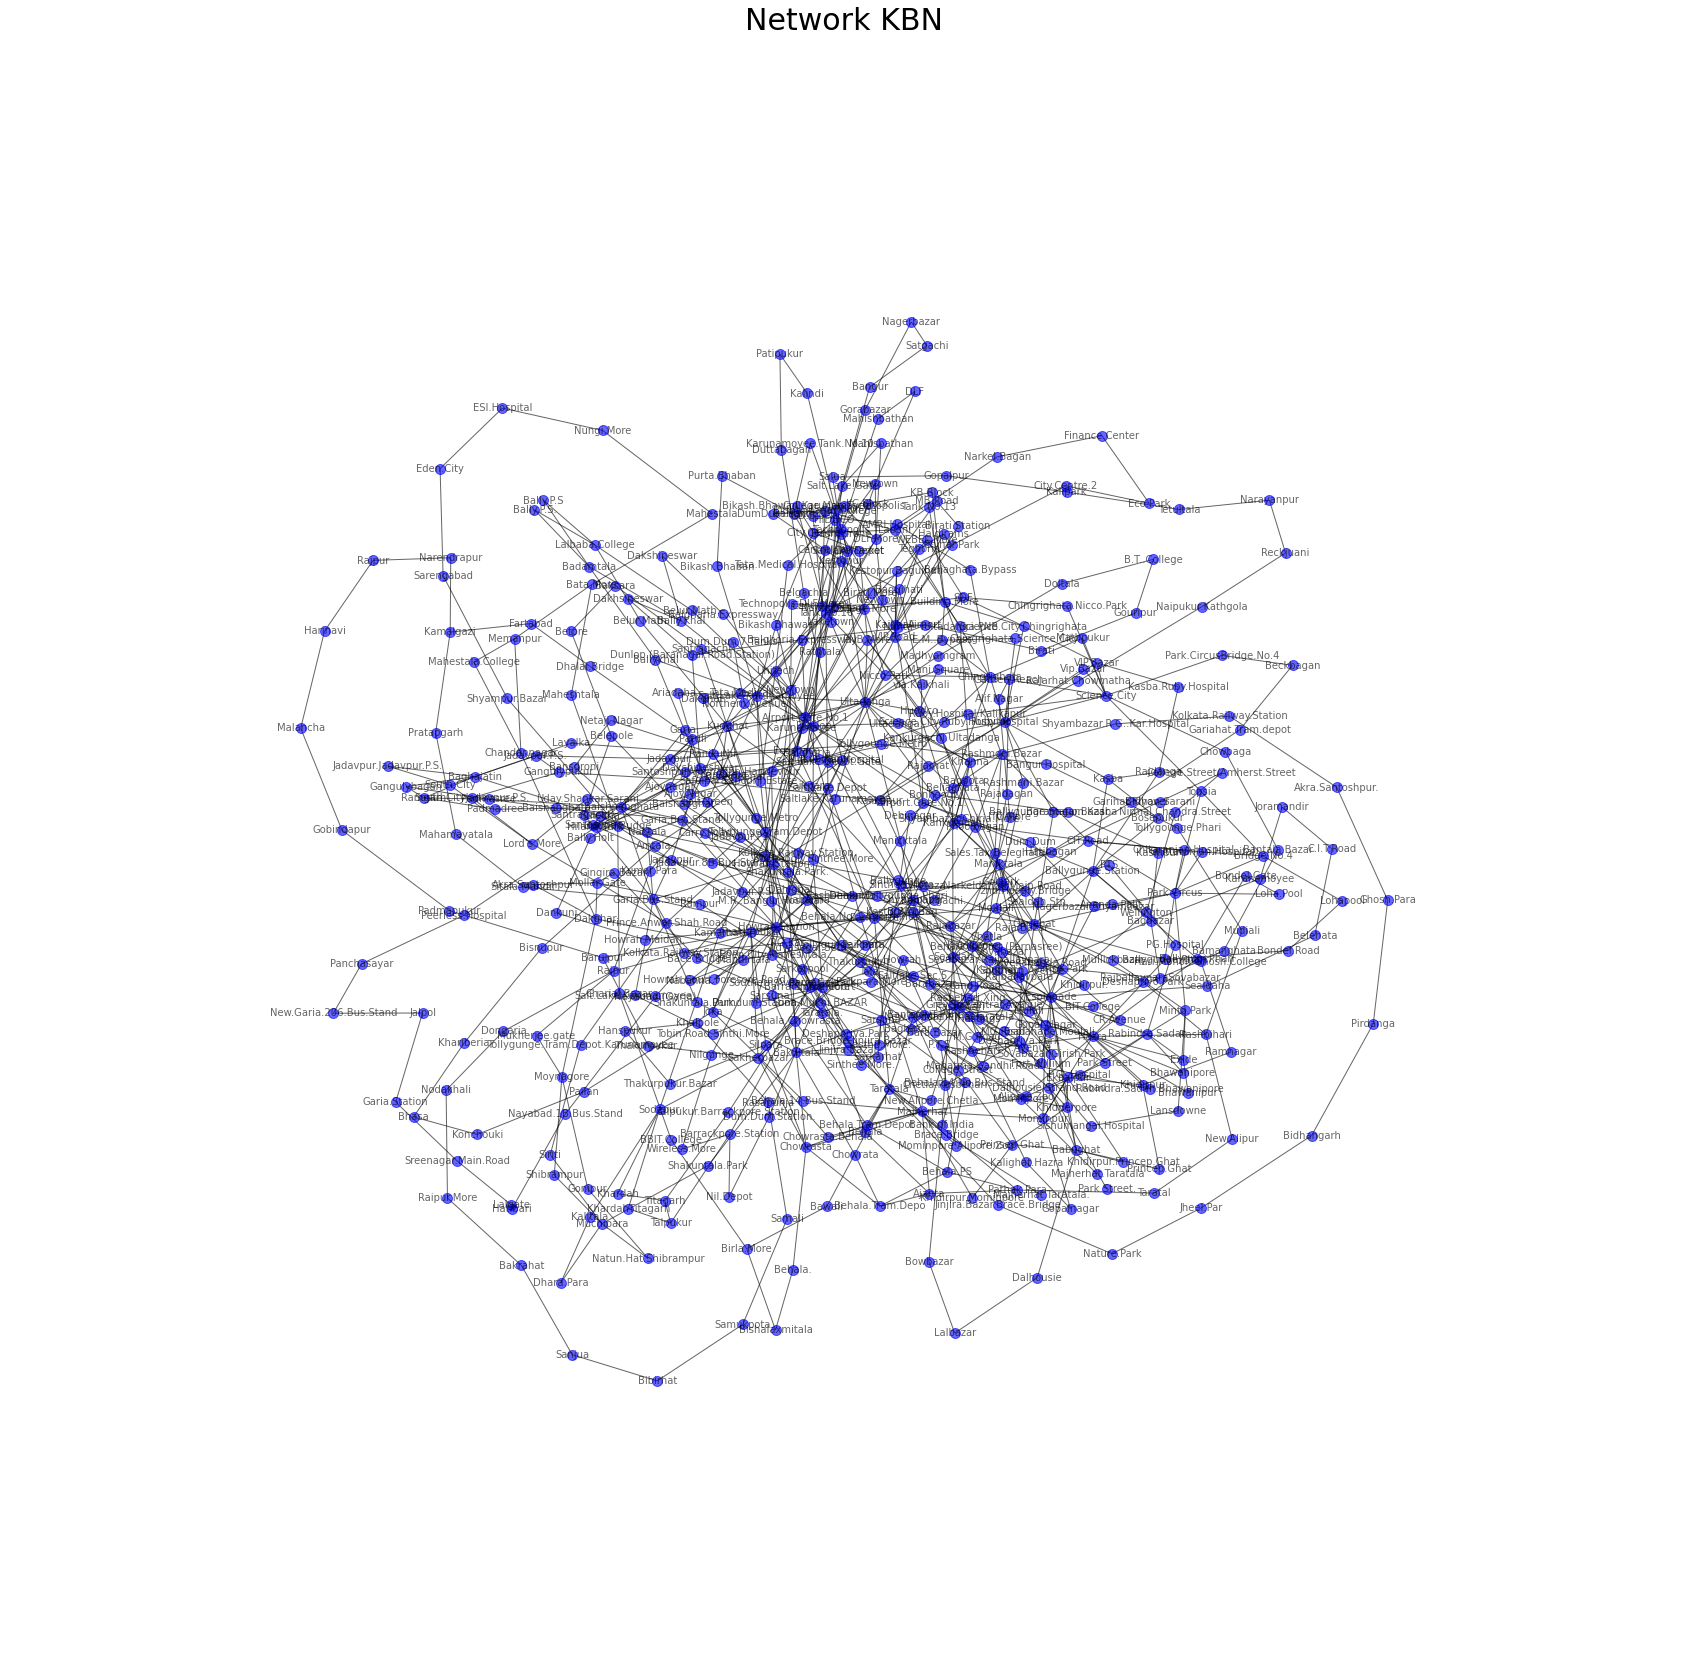

In [4]:
pos = nx.spring_layout(G_pesato, k=0.1)
plt.rcParams["figure.figsize"] = (30,30)
nx.draw_networkx(G_pesato, pos=pos, node_size=100, edge_color="black", alpha=0.6, with_labels=True,
                node_color="blue",font_size=10,font_color="black")
plt.title("Network KBN", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

## Large scale

In [5]:
#La rete è connesssa?
print('\nNetwork is connected?\n',nx.is_connected(G_pesato))                          
comps = sorted(nx.connected_components(G_pesato),
               key=len, reverse=True)


Network is connected?
 True


In [6]:
#average path length
apl=[]
apl.append((round(nx.average_shortest_path_length(G_non_pesato),3)))
apl.append((round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
df=pd.DataFrame([apl],columns=["Network non pesata","Network pesata"])
#diametro
diametro=[]
diametro.append(nx.diameter(G_non_pesato))
diametro.append(nx.diameter(G_pesato))
df_length = len(df)
df.loc[df_length] = diametro
#density
density=[]
density.append(round(nx.density(G_non_pesato),4))
density.append(round(nx.density(G_pesato),4))
df_length = len(df)
df.loc[df_length] = density
# average local clustering
alc=[]
alc.append(round(nx.average_clustering(G_non_pesato),4))
alc.append(round(nx.average_clustering(G_pesato,weight='Weight'),4))
df_length = len(df)
df.loc[df_length] = alc
#global clustering
global_clustering=[]
global_clustering.append(round(nx.transitivity(G_non_pesato),3))
global_clustering.append(round(nx.transitivity(G_pesato),3))
df_length = len(df)
df.loc[df_length] = global_clustering
indici=["Average Path Length","Diametro","Density","Average Local Clustering","Global Clustering"]
df.index =indici
df

,Network non pesata,Network pesata
Average Path Length,5.7710,7.5670
Diametro,16.0000,16.0000
Density,0.0065,0.0065
Average Local Clustering,0.0793,0.0061
Global Clustering,0.0760,0.0760


# Small scale

In [7]:
#calcolo del grado per la network pesata e non pesata
nx.set_node_attributes(G_non_pesato, name='unweighted_degree', values=dict(nx.degree(G_non_pesato)))
nx.set_node_attributes(G_pesato, name='unweighted_degree', values=dict(nx.degree(G_pesato)))
nx.set_node_attributes(G_pesato, name='weighted_degree', values=dict(nx.degree(G_pesato, weight='Weight')))

#calcolo degree centrality
nx.set_node_attributes(G_non_pesato, name='degree_centrality', values=nx.degree_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='degree_centrality', values=nx.degree_centrality(G_pesato))

#calcolo betweeness centrality
nx.set_node_attributes(G_non_pesato, name='betweenness', values=nx.betweenness_centrality(G_non_pesato, normalized=True))
nx.set_node_attributes(G_pesato, name='betweenness', values=nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight"))

#calcolo closeness
nx.set_node_attributes(G_non_pesato, name='closeness', values=nx.closeness_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='closeness', values=nx.closeness_centrality(G_pesato))

#calcolo eigenvector
nx.set_node_attributes(G_non_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_pesato, weight="Weight"))

#calcolo page rank
nx.set_node_attributes(G_non_pesato, name='page_rank', values=nx.pagerank(G_non_pesato))
nx.set_node_attributes(G_pesato, name='page_rank', values=nx.pagerank(G_pesato, weight="Weight"))

In [8]:
#creazione del data frame con le varie misure small scale per la rete non pesata
unweightedDF = pd.DataFrame(dict(G_non_pesato.nodes(data=True))).T
unweightedDF

,unweighted_degree,degree_centrality,betweenness,closeness,eigenvector,page_rank
Howrah.Station,20.0,0.038610,0.171515,0.261616,0.303615,0.009173
Barabazar,9.0,0.017375,0.024914,0.232704,0.164389,0.004033
Dalhousie/Strand.Road,6.0,0.011583,0.007917,0.210740,0.131537,0.002875
Manicktala,2.0,0.003861,0.003359,0.219492,0.064676,0.001036
Thakurpukur.,5.0,0.009653,0.018925,0.213785,0.066161,0.002327
...,...,...,...,...,...,...
Finance.Center,2.0,0.003861,0.000846,0.145179,0.001647,0.001512
Narkel.Bagan,2.0,0.003861,0.004284,0.167909,0.009188,0.001352
MB.Road,2.0,0.003861,0.002729,0.168127,0.003928,0.001527
Birati.Station,2.0,0.003861,0.000470,0.151197,0.001023,0.001555


In [9]:
#creazione del data frame con le varie misure small scale per la rete pesata
weightedDF = pd.DataFrame(dict(G_pesato.nodes(data=True))).T
weightedDF

,unweighted_degree,weighted_degree,degree_centrality,betweenness,closeness,eigenvector,page_rank
Howrah.Station,20.0,32.0,0.038610,0.227302,0.261616,1.157213e-01,0.007823
Barabazar,9.0,47.0,0.017375,0.015503,0.232704,3.632426e-01,0.008230
Dalhousie/Strand.Road,6.0,50.0,0.011583,0.003861,0.210740,4.586851e-01,0.007620
Manicktala,2.0,2.0,0.003861,0.003757,0.219492,1.012222e-02,0.000643
Thakurpukur.,5.0,6.0,0.009653,0.025495,0.213785,1.021911e-02,0.001672
...,...,...,...,...,...,...,...
Finance.Center,2.0,2.0,0.003861,0.003931,0.145179,1.802202e-08,0.001277
Narkel.Bagan,2.0,2.0,0.003861,0.007544,0.167909,6.336174e-07,0.001028
MB.Road,2.0,2.0,0.003861,0.003040,0.168127,7.316975e-07,0.001326
Birati.Station,2.0,2.0,0.003861,0.000901,0.151197,2.277927e-08,0.001305


# Degree

In [10]:
topNodes = 15
unweightedDF["Label"]=unweightedDF.index
weightedDF["Label"]=weightedDF.index

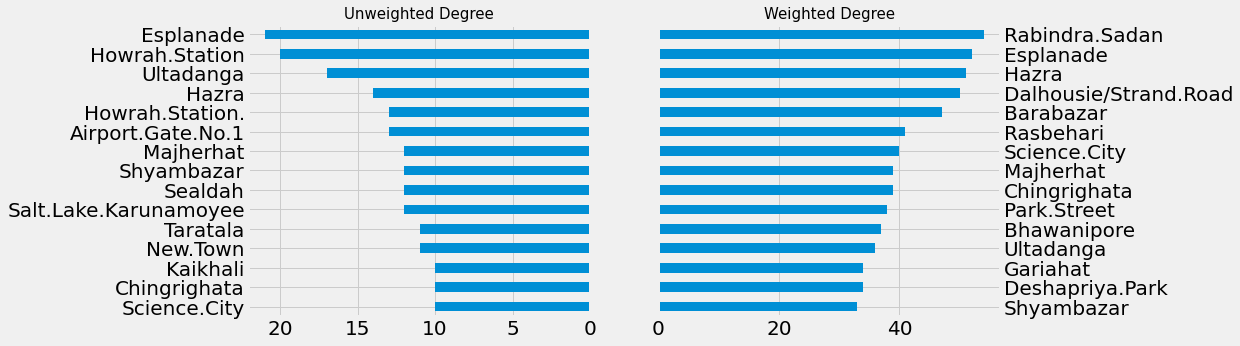

In [41]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='unweighted_degree', ascending=False)[:topNodes].plot(x='Label', y='unweighted_degree', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted Degree", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='weighted_degree', ascending=False)[:topNodes].plot(x='Label', y='weighted_degree', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted Degree", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

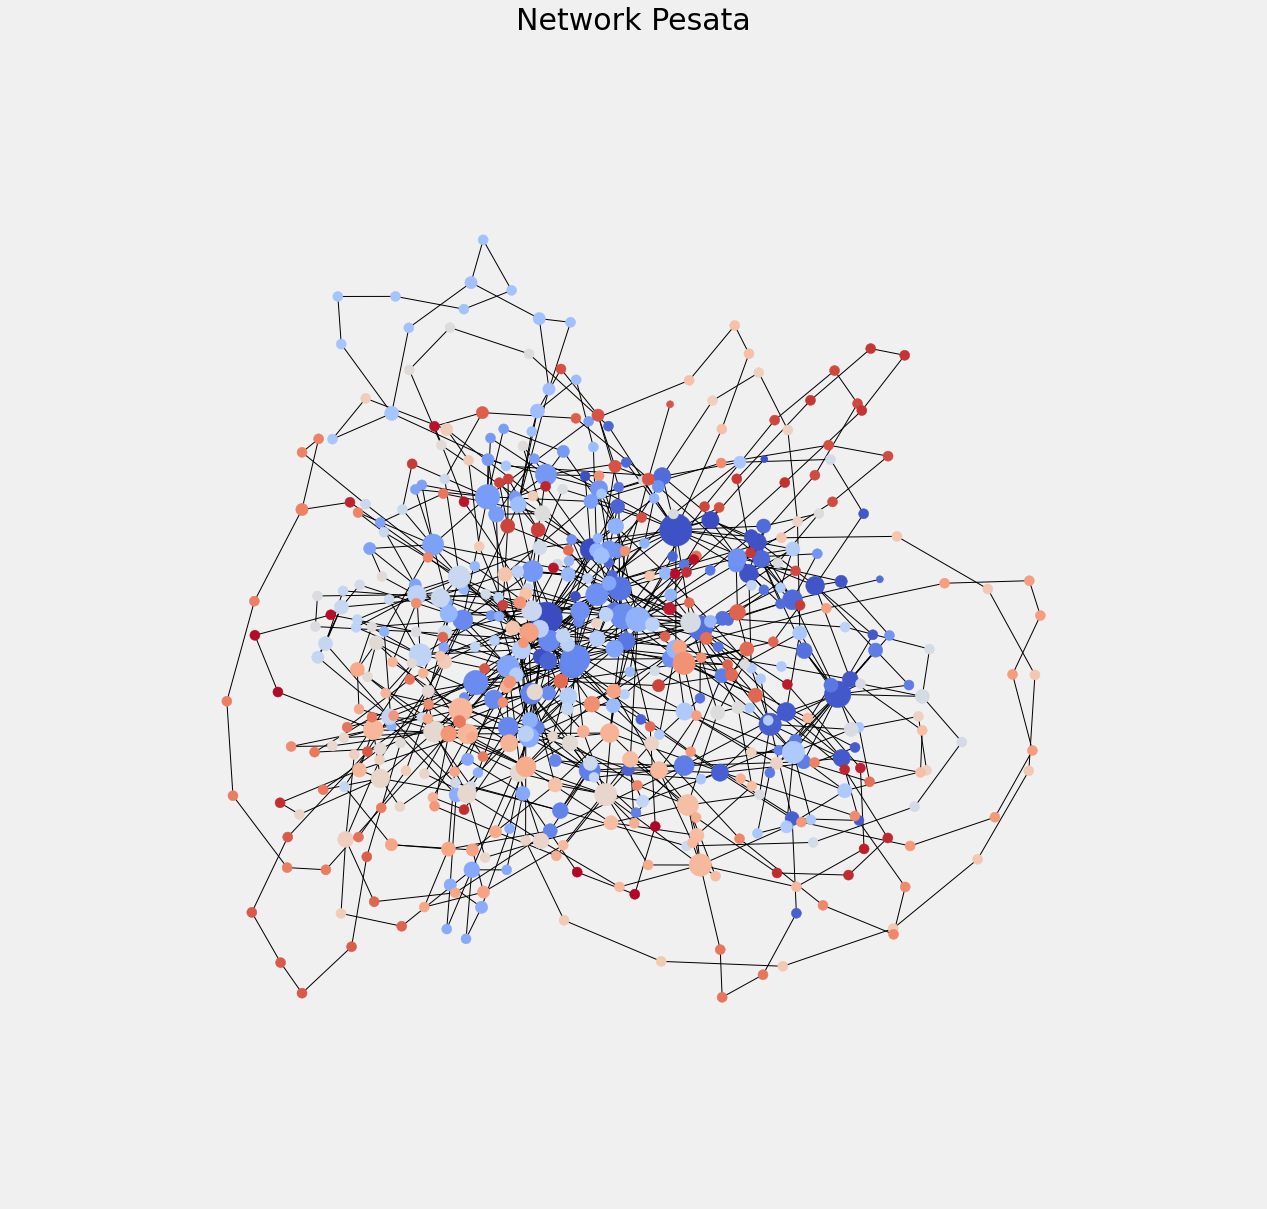

In [42]:
pos = nx.spring_layout(G_pesato, k=0.1)
color_lookup = {k:v for v, k in enumerate(sorted(set(G_pesato.nodes())))}
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
node_colors = [mapper.to_rgba(i) for i in color_lookup.values()]
d = dict(list(nx.degree(G_pesato)))
node_sizes = [v*50 if v <= 30 else v*600 for v in d.values()]
plt.rcParams["figure.figsize"] = (20,20)
nx.draw_networkx(G_pesato, pos=pos, node_size=node_sizes, node_color=node_colors, edge_color="black", with_labels=False, font_size=12)
plt.title("Network Pesata", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

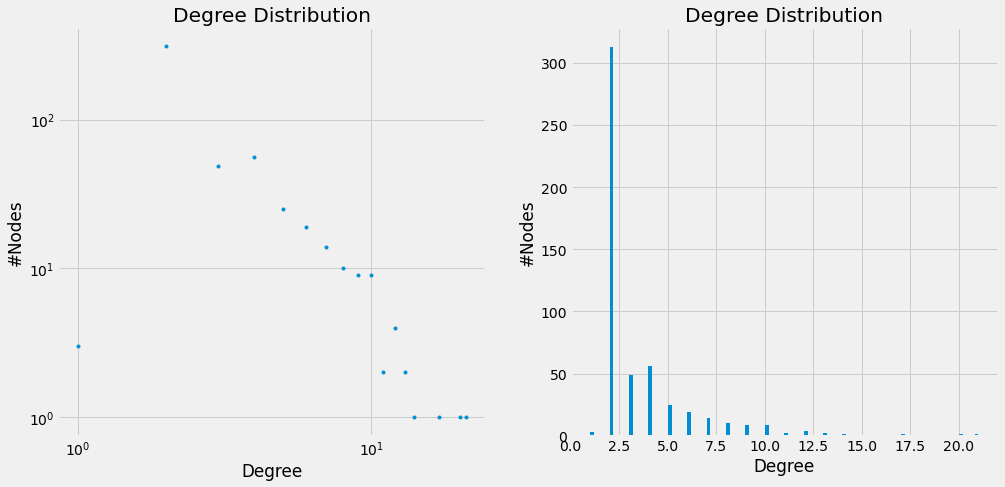

In [13]:
hist = nx.degree_histogram(G_pesato)

plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist)), hist,'.')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

degree_sequence = [G_pesato.degree(n) for n in G_pesato.nodes]

plt.subplot(1, 2, 2)
counts, bins, patches = plt.hist(degree_sequence,bins=100)

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

In [14]:
#creazione di un dataframe per una visualizzazione più rapida dei vari gradi e le relative frequenze
degree_counts = Counter(degree_sequence)
sorted_degree = sorted(degree_counts.items(), 
                       key=lambda item: item[1],reverse=True)
list_gradi=[]
conteggi=[]
for i in range(len(sorted_degree)):
    list_gradi.append(sorted_degree[i][0])
    conteggi.append(sorted_degree[i][1])
df_conteggi=pd.DataFrame(list_gradi,columns=["Grado"])
df_conteggi['Frequenze']=conteggi
df_conteggi


,Grado,Frequenze
0,2,313
1,4,56
2,3,49
3,5,25
4,6,19
5,7,14
6,8,10
7,9,9
8,10,9
9,12,4


# Degree Centrality

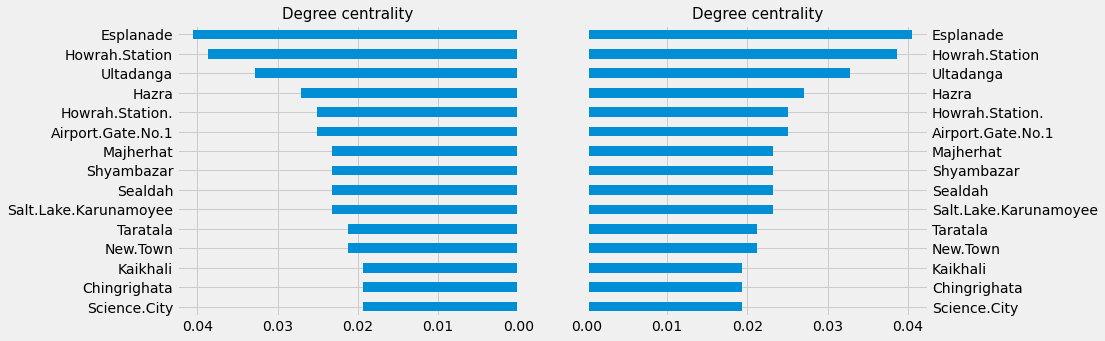

In [15]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Degree centrality", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Degree centrality", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [16]:
if not os.path.isdir('img_kbn'):
    os.mkdir('img_kbn')
title = 'Degree centrality'
adjusted_node_size = dict([(node, 5+degree*175) for node, degree in nx.degree_centrality(G_pesato).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("degree_centrality","@degree_centrality")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.degree_centrality(G_pesato).values()), high=max(nx.degree_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Degree centrality.html'

# Betweenness

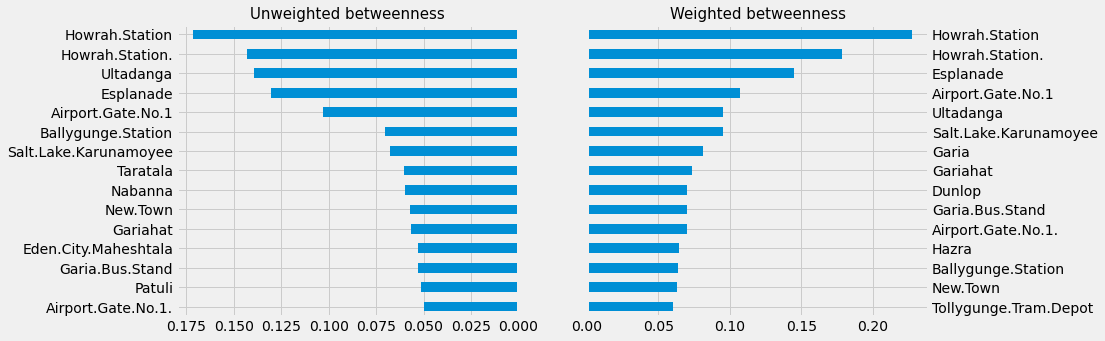

In [17]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted betweenness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted betweenness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

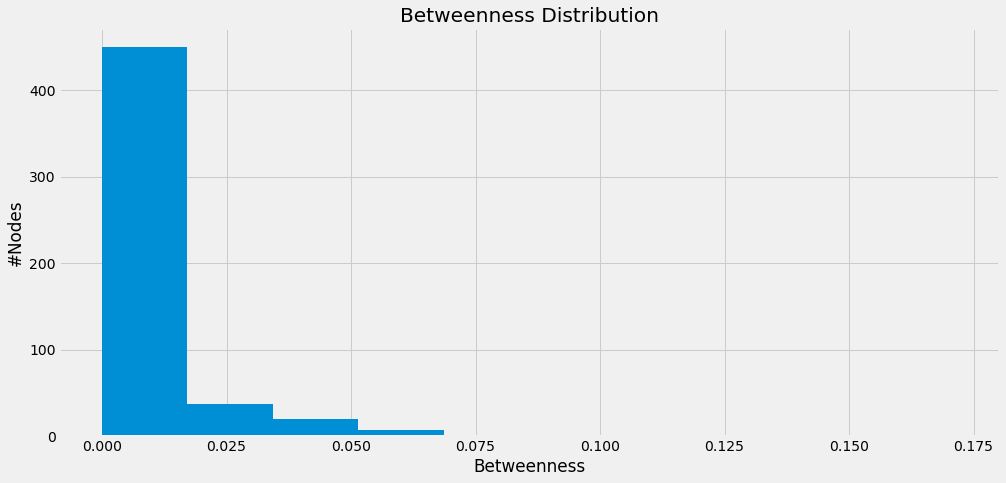

In [18]:
#grafico della distribuzione di frequenze per la betweenness
B = nx.betweenness_centrality(G_pesato,normalized=True)
betweenness_sequence = list(B.values())

counts, bins, patches = plt.hist(betweenness_sequence,bins=10)
plt.title("Betweenness Distribution")
plt.xlabel("Betweenness")
plt.ylabel("#Nodes")
plt.show()

In [19]:
if not os.path.isdir('img_kbn'):             
    os.mkdir('img_kbn')
title = 'Weighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_pesato, normalized=True, weight="Weight").values()), high=max(nx.betweenness_centrality(G_pesato, weight="Weight",normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Weighted betweenness.html'

In [20]:
if not os.path.isdir('img_kbn'):             
    os.mkdir('img_kbn')
title = 'Unweighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_non_pesato, normalized=True).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_non_pesato, normalized=True).values()), high=max(nx.betweenness_centrality(G_non_pesato, normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Unweighted betweenness.html'

# Closeness

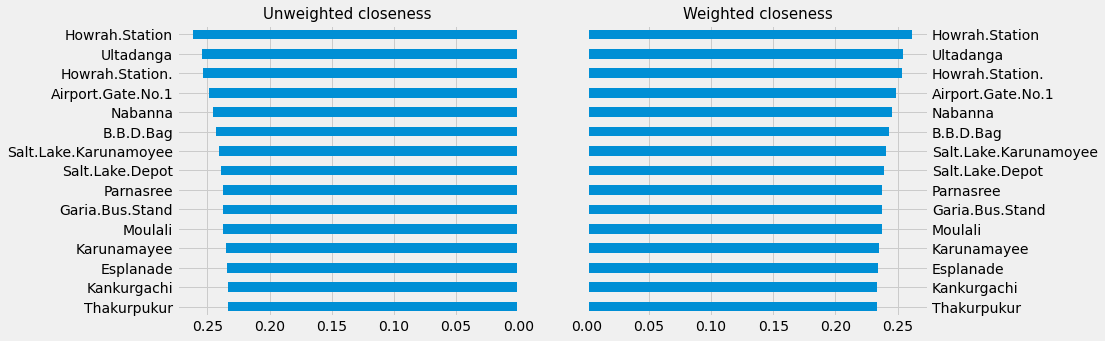

In [21]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted closeness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted closeness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [22]:
if not os.path.isdir('img_kbn'):             
    os.mkdir('img_kbn')
title = 'Closeness'
adjusted_node_size = dict([(node, 5+closeness*70) for node, closeness in nx.closeness_centrality(G_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("closeness","@closeness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.closeness_centrality(G_pesato).values()), high=max(nx.closeness_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Closeness.html'

# Eigenvector

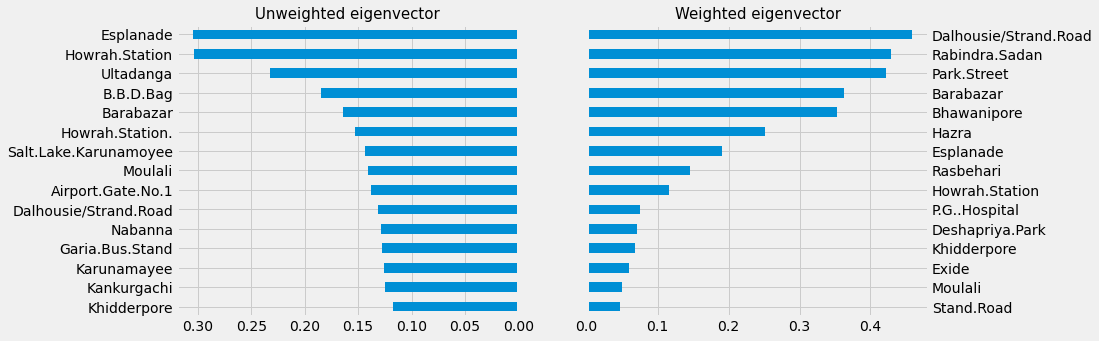

In [23]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted eigenvector", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted eigenvector", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [24]:
if not os.path.isdir('img_kbn'):             
    os.mkdir('img_kbn')
title = 'Weighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_pesato,weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_pesato,weight="Weight").values()), high=max(nx.eigenvector_centrality(G_pesato,weight="Weight").values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Weighted Eigenvector.html'

In [25]:
if not os.path.isdir('img_kbn'):             
    os.mkdir('img_kbn')
title = 'Unweighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_non_pesato).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_non_pesato).values()), high=max(nx.eigenvector_centrality(G_non_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Unweighted Eigenvector.html'

# Page Rank

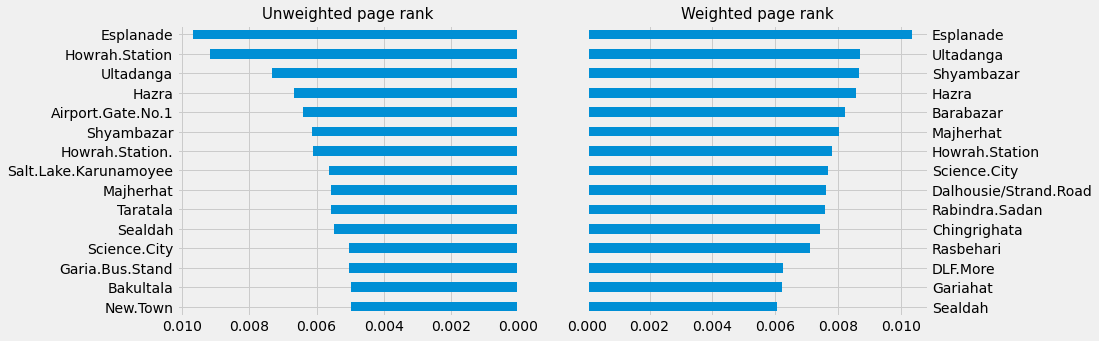

In [26]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted page rank", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted page rank", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [27]:
if not os.path.isdir('img_kbn'):             
    os.mkdir('img_kbn')
title = 'Weighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*950) for node, page_rank in nx.pagerank(G_pesato, weight="Weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_pesato, weight="Weight").values()), high=max(nx.pagerank(G_pesato, weight="Weight").values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Weighted Pagerank.html'

In [28]:
if not os.path.isdir('img_kbn'):             
    os.mkdir('img_kbn')
title = 'Unweighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*950) for node, page_rank in nx.pagerank(G_non_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_non_pesato).values()), high=max(nx.pagerank(G_non_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_kbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_kbn\\Unweighted Pagerank.html'

# Medium Scale

In [43]:
G_core_3 = nx.k_core(G_pesato, 3)

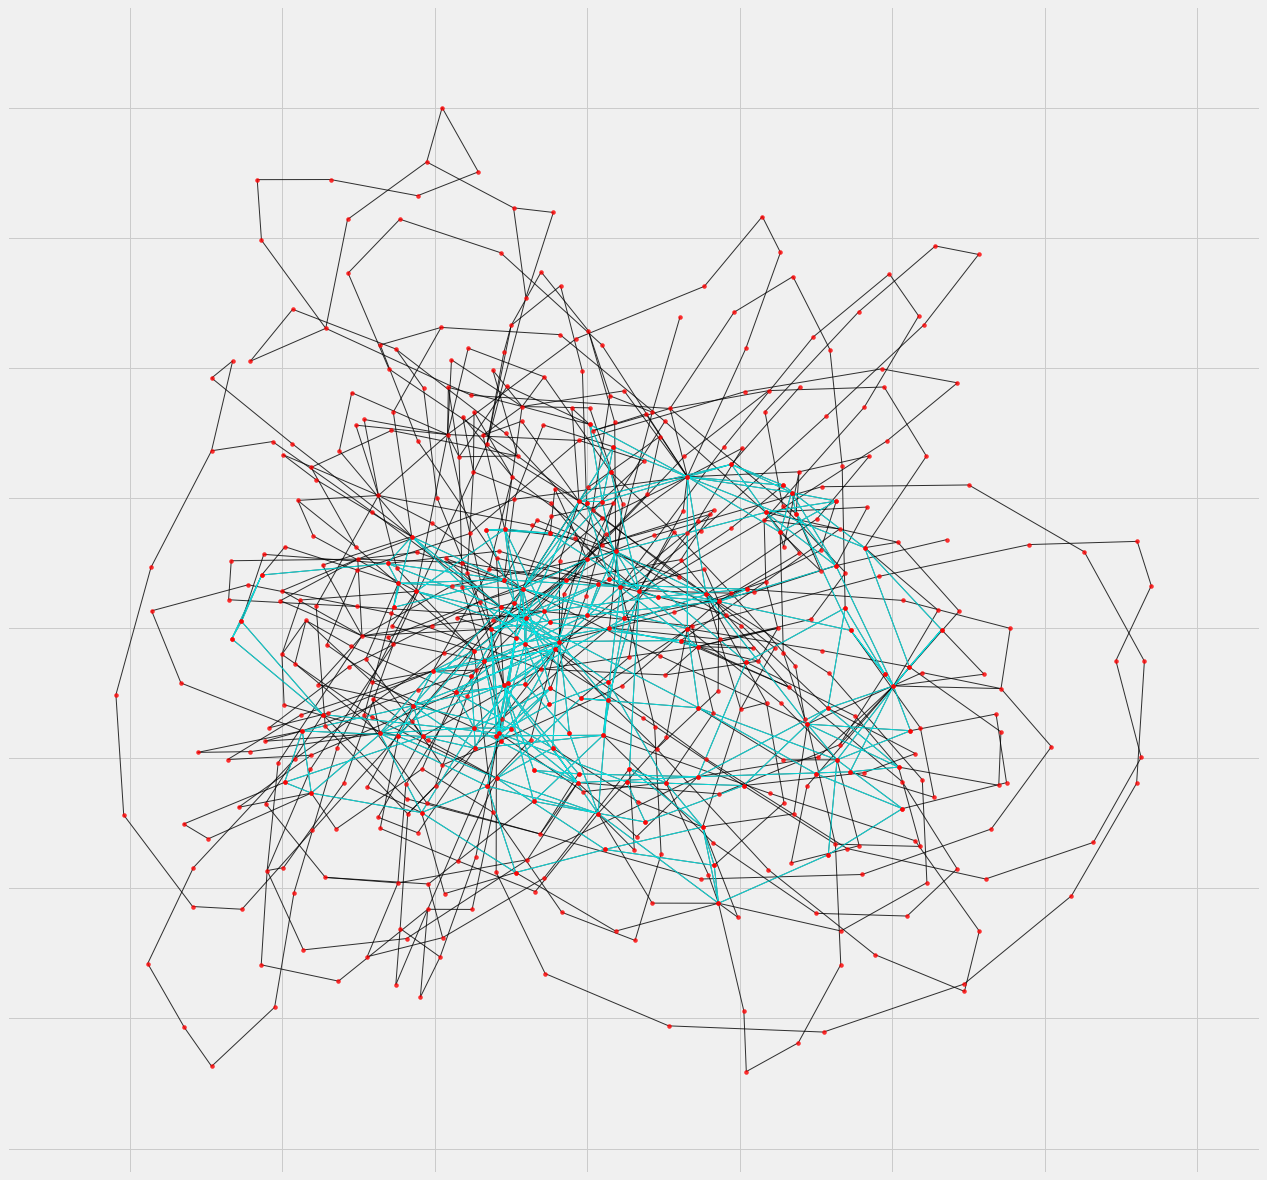

In [44]:
# grafico k kore = 3
nx.draw_networkx(
    G_pesato, pos=pos, node_size=15, edge_color="black", alpha=0.8, with_labels=False,node_color="red")
nx.draw_networkx(
    G_core_3, pos=pos, node_size=15, edge_color="cyan", alpha=0.8, with_labels=False,node_color="red")
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

In [45]:
def tie_strength(G, v, w):
    # Get neighbors of nodes v and w in G
    v_neighbors = set(G.neighbors(v))
    w_neighbors = set(G.neighbors(w))
    # Return size of the set intersection
    return 1 + len(v_neighbors & w_neighbors)

strength = dict(
    ((v,w), tie_strength(G_pesato, v, w))
    for v, w in G_pesato.edges())

def bridge_span(G):
    # Get list of edges
    edges = G.edges()
    # Copy G
    G = nx.Graph(G)
    # Create result dict
    result = dict()
    for v, w in edges:
        # Temporarily remove edge
        G.remove_edge(v, w)
        # Find distance with edge removed
        try:
            d = nx.shortest_path_length(G, v, w)
            result[(v, w)] = d
        except nx.NetworkXNoPath:
            result[(v, w)] = float('inf')
        # Restore edge
        G.add_edge(v, w)
    return result

span = bridge_span(G_pesato)

In [46]:
# edges ordinati per tie strength
ordered_edges = sorted(strength.items(), key=lambda x: x[1])
print('Edge\t  Strength\tSpan')

for e, edge_strength in ordered_edges:
    print('{}\t{}\t{}'.format(
        str(e), edge_strength, span[e]
    ))

Edge	  Strength	Span
('Howrah.Station', 'Nabanna')	1	3
('Howrah.Station', 'Howrah.Maidan.')	1	5
('Howrah.Station', 'Taratala.')	1	3
('Howrah.Station', 'Moulali')	1	3
('Howrah.Station', 'Garia.Bus.Stand.')	1	3
('Howrah.Station', 'Sona.Mukhi.BAZAR')	1	5
('Howrah.Station', 'Dumdum.Station.')	1	5
('Howrah.Station', 'Howrah.Court.Foresore.Road')	1	3
('Howrah.Station', 'Saltlake.Sec.5')	1	3
('Howrah.Station', 'Thakurpukur')	1	4
('Howrah.Station', 'Raipur')	1	6
('Howrah.Station', 'Nilgunge')	1	6
('Howrah.Station', 'Baruipur')	1	4
('Howrah.Station', 'Sapoorji.Estate')	1	4
('Barabazar', 'Dalhousie/Strand.Road')	1	3
('Barabazar', 'Manicktala')	1	4
('Barabazar', 'Thakurpukur.')	1	4
('Barabazar', 'Mahatma.Gandhi.Road')	1	3
('Barabazar', 'M.G.Road')	1	3
('Barabazar', 'MG.Road')	1	5
('Dalhousie/Strand.Road', 'Park.Street.')	1	inf
('Manicktala', 'Ultadanga')	1	4
('Thakurpukur.', 'Kankurgachi.')	1	3
('Thakurpukur.', 'Kankurgachi')	1	3
('Mahatma.Gandhi.Road', 'Central.Avenue')	1	3
('Esplanade', 'Saltla

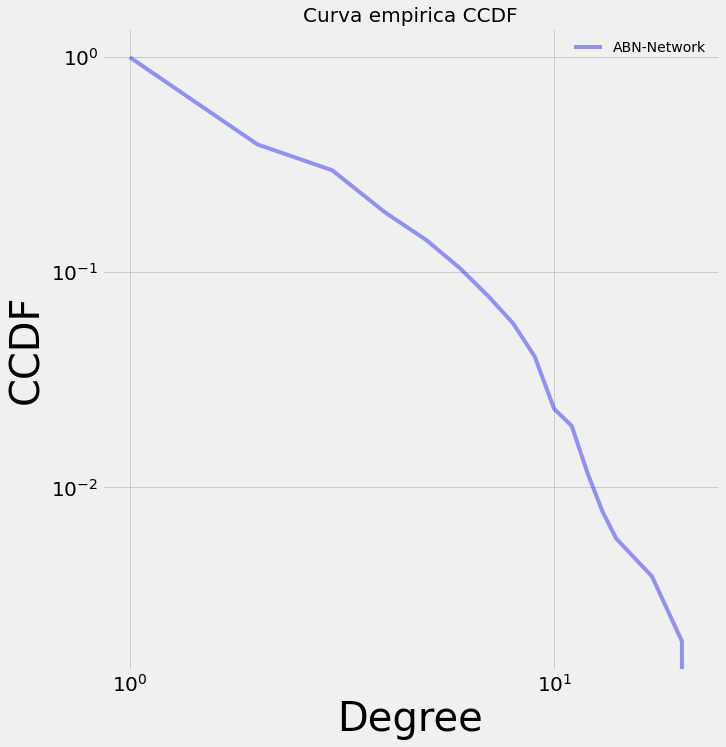

In [47]:
# grafico ccdf
degrees = [G_pesato.degree(u) for u in G_pesato]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, label="ABN-Network")
decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.title("Curva empirica CCDF", fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()


# Random Network Erdos-Renyi

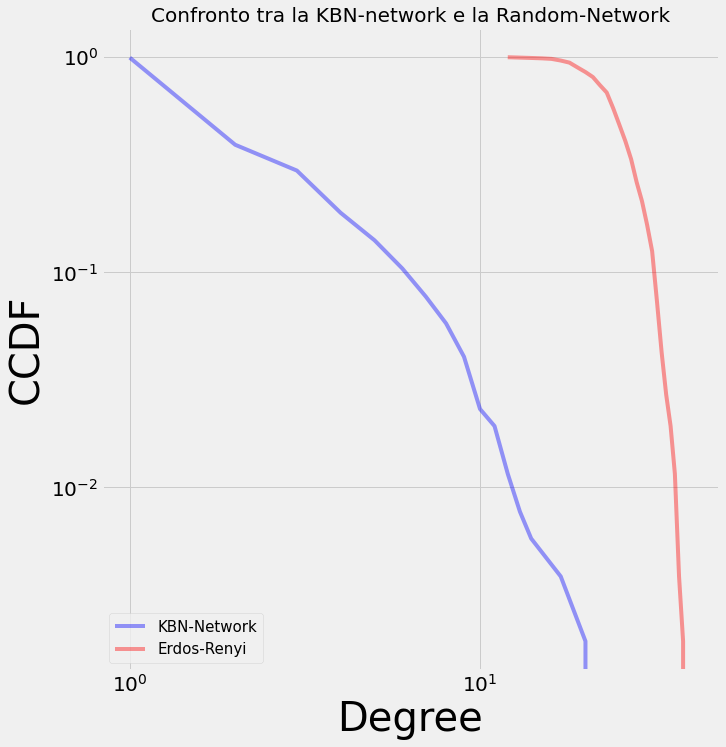

Average degree Random Network: 25.58766859344894
Average degree KBN Network: 3.3834296724470136
Il global clustering della network KBN è:  0.076
Il global clustering della random network è:  0.049
L'APL della network KBN è:  7.567
L'APL della random network è:  2.219


In [34]:
erdos_renyi=nx.erdos_renyi_graph(len(G_pesato),0.05,seed=1)
degrees_er = [erdos_renyi.degree(i) for i in erdos_renyi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, xlabel='Degree', ylabel="CCDF", label="KBN-Network")


cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Renyi")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la KBN-network e la Random-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()


print("Average degree Random Network:",sum(dict(erdos_renyi.degree()).values())/len(erdos_renyi))
print("Average degree KBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network KBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della random network è: ",(round(nx.transitivity(erdos_renyi),3)))
print("L'APL della network KBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL della random network è: ",(round(nx.average_shortest_path_length(erdos_renyi),3)))


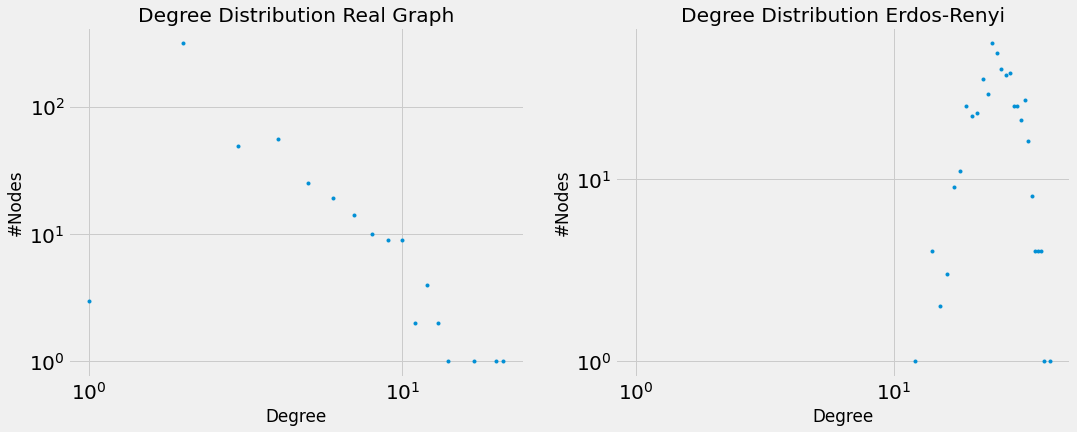

In [35]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(erdos_renyi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Erdos-Renyi")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Small word Watts-Strogatz

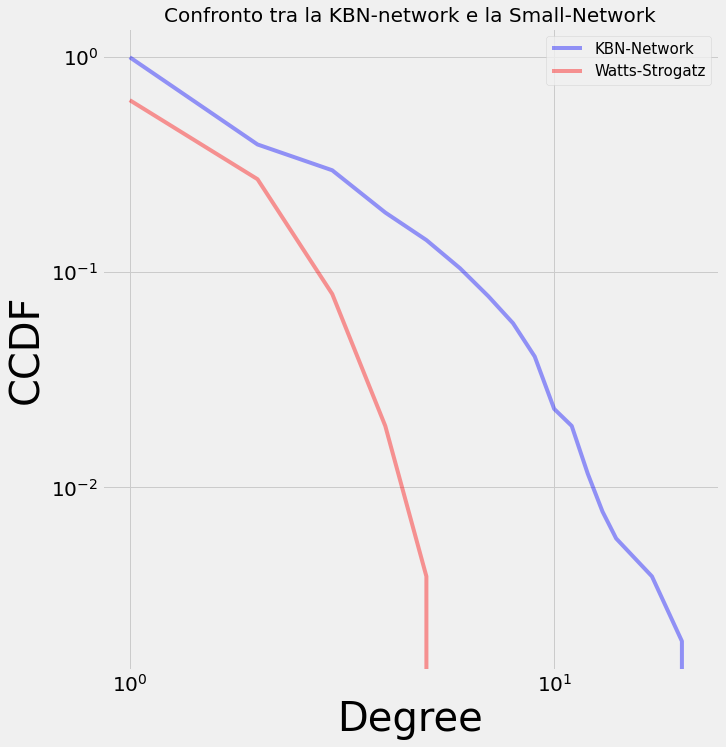

Average degree Small word: 2.0
Average degree KBN Network: 3.3834296724470136
Il global clustering della network KBN è:  0.076
Il global clustering della Small word network è:  0


In [36]:
watts_strogatz = nx.watts_strogatz_graph(len(G_pesato.nodes), int(round(2*len(G_pesato.edges())/len(G_pesato))), 1, seed=1)
degrees_ws = [watts_strogatz.degree(i) for i in watts_strogatz]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="KBN-Network")


cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Watts-Strogatz")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la KBN-network e la Small-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Small word:",sum(dict(watts_strogatz.degree()).values())/len(watts_strogatz))
print("Average degree KBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network KBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della Small word network è: ",(round(nx.transitivity(watts_strogatz),3)))


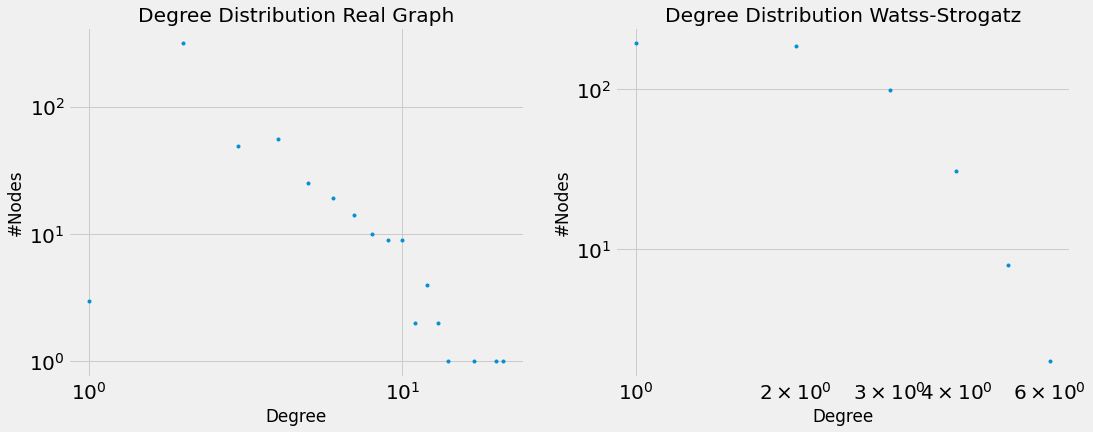

In [37]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(watts_strogatz)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Watss-Strogatz")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Barabasi Albert

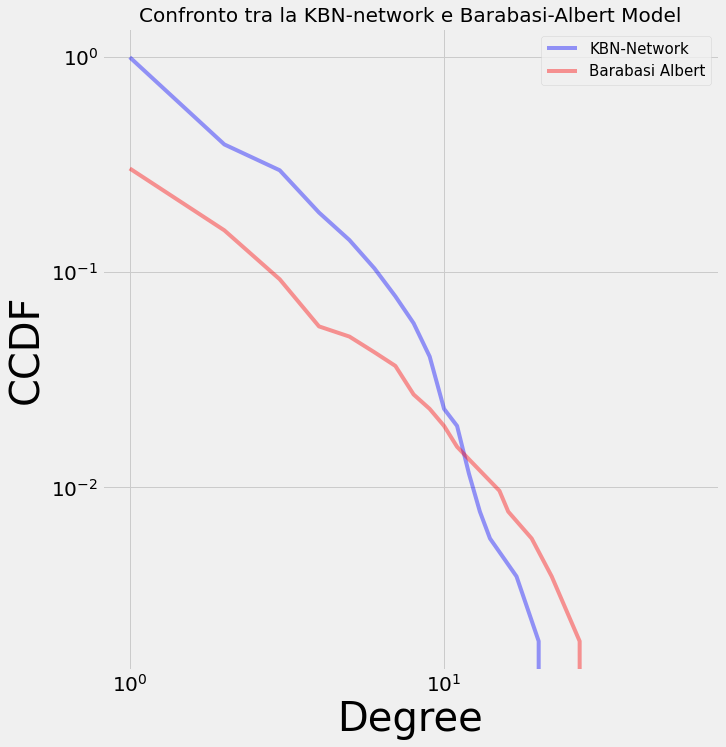

Average degree Barabasi-Albert: 1.9961464354527938
Average degree KBN Network: 3.3834296724470136
Il global clustering della network KBN è:  0.076
Il global clustering del modello di Barabasi-Albert è:  0
L'APL della network KBN è:  7.567
L'APL del modello di Barabasi- Albert è:  6.204


In [38]:
barabasi = nx.barabasi_albert_graph(len(G_pesato.nodes), 1,seed=1)
degrees_barabasi = [barabasi.degree(i) for i in barabasi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="KBN-Network")


cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la KBN-network e Barabasi-Albert Model", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Barabasi-Albert:",sum(dict(barabasi.degree()).values())/len(barabasi))
print("Average degree KBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network KBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering del modello di Barabasi-Albert è: ",(round(nx.transitivity(barabasi),3)))
print("L'APL della network KBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL del modello di Barabasi- Albert è: ",(round(nx.average_shortest_path_length(barabasi),3)))

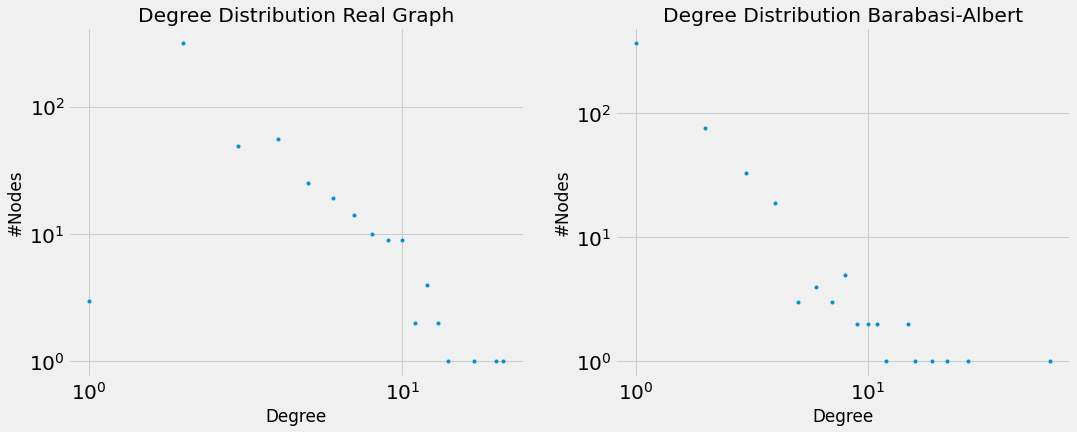

In [39]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(barabasi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Barabasi-Albert")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Confronto tra i vari modelli della CCDF

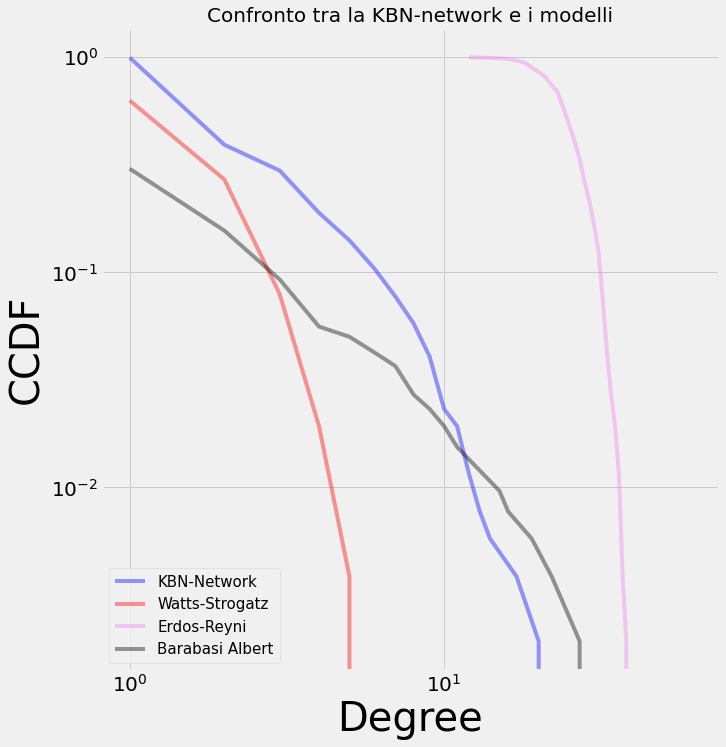

In [40]:
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="KBN-Network")

cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Watts-Strogatz")

cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='violet', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Reyni")

cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='black', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
plt.legend(["KBN-Network","Watts-Strogatz","Erdos-Renyi","Barabasi-Albert"])
plt.title("Confronto tra la KBN-network e i modelli", fontsize=20)
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.legend(fontsize=15)
plt.show()